In [1]:
import os
import sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.decomposition import PCA
import seaborn as sns
import datetime
from scipy.stats import sem
import matplotlib.cm as cm
import pathlib
import traceback
import gc

# Parameters

In [2]:
netname = 'pnet'
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn_vision/'
activations_dir = f'{engram_dir}activations/{netname}/'
pca_activations_dir = f'{engram_dir}activations_pca/{netname}/'
pickles_dir = f'{engram_dir}pickles/'
bg_types = ['gaussian_noise', 'impulse_noise']
snr_types = [1,2,3]

# Helper function

In [3]:
def get_data(conv_idx, t, bg, snr):
    clean_activ_dir = f'{activations_dir}none_lvl_0/'
    for results_file in os.listdir(clean_activ_dir):
        results_filepath = f'{clean_activ_dir}{results_file}'
        clean_results = h5py.File(results_filepath, 'r')
    clean_activ = np.array(clean_results[f'{conv_idx}_{t}_activations'])
    n_data = clean_activ.shape[0]
    clean_activ = clean_activ.reshape((n_data, -1))

    activ_dir = f'{activations_dir}{bg}_lvl_{snr}/'
    for results_file in os.listdir(activ_dir):
        results_filepath = f'{activ_dir}{results_file}'
        results = h5py.File(results_filepath, 'r')
    activ = np.array(results[f'{conv_idx}_{t}_activations'])
    n_data = activ.shape[0]
    activ = activ.reshape((n_data, -1))

    return activ, clean_activ

# Measure factorization

In [4]:
def get_explained_var(activ, pca):
    cum_var = np.cumsum(pca.explained_variance_ratio_)
    K = np.argwhere(cum_var>0.9)[0].item()
    cum_var_K = cum_var[K]
    activ_centered = activ - pca.mean_[None,:]
    total_var = np.sum(np.square(activ_centered))/(activ.shape[0]-1)
    projected_activ = activ_centered @ (pca.components_[:K+1]).T
    sample_size = projected_activ.shape[0]-1
    explained_var = np.sum(np.square(projected_activ), axis=0)/sample_size
    clean_explained = np.sum(explained_var/total_var)
    return clean_explained

In [6]:
bgs = []
snrs = []
convs = []
ts = []
factorization = []
shuffle_factorization = []
factorization_ratio = []
for bg in bg_types:
    for snr in snr_types:
        for conv_idx in [1,2,3,4,5,6,7,8]:
            for t in [0,1,2,3,4]:
                activ, clean_activ = get_data(conv_idx, t, bg, snr)
                bgs.append(bg)
                snrs.append(snr)
                convs.append(conv_idx)
                ts.append(t)
                print(f'{bg}, {snr}, conv {conv_idx}, t {t}')
                print(activ.shape)
                
                # Noisy activ projected onto clean subspace
                clean_pca_path = f'{pca_activations_dir}PCA_clean_conv{conv_idx}_t{t}.p'
                with open(clean_pca_path, 'rb') as f:
                    clean_pca = pickle.load(f)
                clean_explained = get_explained_var(activ, clean_pca)
                del clean_pca
                gc.collect()
                
                # Shuffle activ projected onto shuffle subspace
                shuff_pca_path = f'{pca_activations_dir}PCA_{bg}_lvl_{snr}_shufflehalf_conv{conv_idx}_t{t}.p'
                with open(shuff_pca_path, 'rb') as f:
                    shuff_pca = pickle.load(f)
                shuff_activ = np.zeros(activ.shape)
                shuff_activ[1::2] = np.copy(clean_activ[1::2])
                shuff_activ[::2] = np.copy(activ[::2])
                shuff_explained = get_explained_var(shuff_activ, shuff_pca)                
                
                factorization.append(clean_explained)
                shuffle_factorization.append(shuff_explained)
                factorization_ratio.append(clean_explained/shuff_explained)
                del shuff_pca
                gc.collect()

df = pd.DataFrame({
    'BG': bgs,
    'SNR': snrs,
    'Conv': convs,
    'T': ts,
    'Factorization': factorization,
    'Shuffle Factorization': shuffle_factorization,
    'Factorization Ratio': factorization_ratio,
    })

gaussian_noise, 1, conv 1, t 0
(600, 401408)
gaussian_noise, 1, conv 1, t 1
(600, 401408)
gaussian_noise, 1, conv 1, t 2
(600, 401408)
gaussian_noise, 1, conv 1, t 3
(600, 401408)
gaussian_noise, 1, conv 1, t 4
(600, 401408)
gaussian_noise, 1, conv 2, t 0
(600, 200704)
gaussian_noise, 1, conv 2, t 1
(600, 200704)
gaussian_noise, 1, conv 2, t 2
(600, 200704)
gaussian_noise, 1, conv 2, t 3
(600, 200704)
gaussian_noise, 1, conv 2, t 4
(600, 200704)
gaussian_noise, 1, conv 3, t 0
(600, 75264)
gaussian_noise, 1, conv 3, t 1
(600, 75264)
gaussian_noise, 1, conv 3, t 2
(600, 75264)
gaussian_noise, 1, conv 3, t 3
(600, 75264)
gaussian_noise, 1, conv 3, t 4
(600, 75264)
gaussian_noise, 1, conv 4, t 0
(600, 31360)
gaussian_noise, 1, conv 4, t 1
(600, 31360)
gaussian_noise, 1, conv 4, t 2
(600, 31360)
gaussian_noise, 1, conv 4, t 3
(600, 31360)
gaussian_noise, 1, conv 4, t 4
(600, 31360)
gaussian_noise, 1, conv 5, t 0
(600, 15680)
gaussian_noise, 1, conv 5, t 1
(600, 15680)
gaussian_noise, 1, con

impulse_noise, 2, conv 6, t 3
(600, 21952)
impulse_noise, 2, conv 6, t 4
(600, 21952)
impulse_noise, 2, conv 7, t 0
(600, 9408)
impulse_noise, 2, conv 7, t 1
(600, 9408)
impulse_noise, 2, conv 7, t 2
(600, 9408)
impulse_noise, 2, conv 7, t 3
(600, 9408)
impulse_noise, 2, conv 7, t 4
(600, 9408)
impulse_noise, 2, conv 8, t 0
(600, 15680)
impulse_noise, 2, conv 8, t 1
(600, 15680)
impulse_noise, 2, conv 8, t 2
(600, 15680)
impulse_noise, 2, conv 8, t 3
(600, 15680)
impulse_noise, 2, conv 8, t 4
(600, 15680)
impulse_noise, 3, conv 1, t 0
(600, 401408)
impulse_noise, 3, conv 1, t 1
(600, 401408)
impulse_noise, 3, conv 1, t 2
(600, 401408)
impulse_noise, 3, conv 1, t 3
(600, 401408)
impulse_noise, 3, conv 1, t 4
(600, 401408)
impulse_noise, 3, conv 2, t 0
(600, 200704)
impulse_noise, 3, conv 2, t 1
(600, 200704)
impulse_noise, 3, conv 2, t 2
(600, 200704)
impulse_noise, 3, conv 2, t 3
(600, 200704)
impulse_noise, 3, conv 2, t 4
(600, 200704)
impulse_noise, 3, conv 3, t 0
(600, 75264)
impuls

In [7]:
bgs = np.array(df['BG'])
snrs = np.array(df['SNR'])
convs = np.array(df['Conv'])
ts = np.array(df['T'])
fact_ratios = np.array(df['Factorization Ratio'])
delta_fact_ratios = []

for i in range(len(bgs)):
    bg = bgs[i]; snr = snrs[i];
    conv = convs[i]; t = ts[i];
    fact = fact_ratios[i];
    idxs = np.logical_and(bgs == bg, snrs == snr)
    idxs = np.logical_and(idxs, convs == conv)
    idxs = np.logical_and(idxs, ts == 0)
    delta_fact_ratios.append(
        fact - np.mean(fact_ratios[idxs])
        )

In [9]:
delta_df = pd.DataFrame({
    'BG': bgs,
    'SNR': snrs,
    'Conv': convs,
    'T': ts,
    '$\Delta$ Factorization': delta_fact_ratios,
})

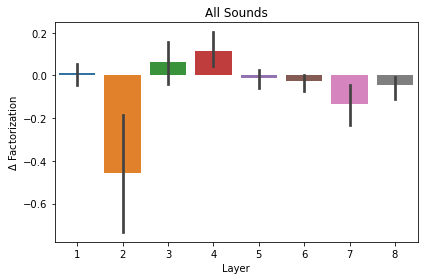

In [10]:
fig, ax = plt.subplots()
sns.barplot(
    x='Conv', y='$\Delta$ Factorization',
    data=delta_df[delta_df['T']==4],
    ax=ax)
ax.set_xlabel('Layer')
ax.set_title('All Sounds')
plt.tight_layout()
plt.savefig('factorization.png', dpi=300)